In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,5)

from scipy import stats

import dask.dataframe as dd

In [3]:
#%pip install dask

In [3]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
data_df = pd.read_csv(path+'/Rawdata_2017-19.csv', sep=',', header=0)
#data_df.reset_index(inplace=True)

In [4]:
data_df['date'] = pd.DatetimeIndex(data_df['date'])

# 1. Data & Packages

In [5]:
data_df["inquiry_with_description"] = data_df["inquiry_name"] + ' ' + data_df["brief_description"]
data_df.head(2)

,Unnamed: 0.1,unique_id,Unnamed: 0,date,time,date_time,agency,agency_name,inquiry_name,brief_description,call_resolution,inquiry_with_description
0,947,120986760,947,2017-01-01,12:00:05 AM,2017-01-01T00:00:05.000,3-1-1,3-1-1 Call Center,Language Assistance,Connect to Language Line.,Transfer to City Agency,Language Assistance Connect to Language Line.
1,850,120985098,850,2017-01-01,12:01:12 AM,2017-01-01T00:01:12.000,NYPD,New York City Police Department,Vehicle Blocking Driveway Complaint,Report a vehicle that is blocking a driveway.,CSMS SR,Vehicle Blocking Driveway Complaint Report a v...


In [6]:
unique_inq_df = pd.DataFrame(data_df['inquiry_with_description'].unique()).rename(columns={0:'Inquiry_names'})
unique_inq_df

,Inquiry_names
0,Language Assistance Connect to Language Line.
1,Vehicle Blocking Driveway Complaint Report a v...
2,Apartment Maintenance Complaint Report a maint...
3,Noise from Neighbor Report a noisy neighbor.
4,Find a Police Precinct or PSA by Name Find a s...
...,...
6801,Taxi Complaint Report a problem with a taxi dr...
6802,"New Year's Day Wednesday, January 1st is New Y..."
6803,Fuel Truck Inspection Get an inspection of fue...
6804,Home Repair Assistance for Seniors Learn about...


# 2. Embeddings

In [7]:
#%pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
model4 = SentenceTransformer('all-MiniLM-L6-v2')
embeddings4 = model4.encode(unique_inq_df['Inquiry_names'], show_progress_bar=True)

Batches: 100%|██████████| 213/213 [00:50<00:00,  4.25it/s]


In [10]:
import pickle
# Save the embeddings to a file
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/05-embeddings'

with open(path+"/embeddings_inq_2017-2019.pickle", "wb") as file:
    pickle.dump(embeddings4, file)

In [7]:
import pickle
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/05-embeddings'

# Load the embeddings from the file
with open(path+"/embeddings_inq_2017-2019.pickle", "rb") as file:
    embeddings4 = pickle.load(file)

In [8]:
embeddings4.shape

(6806, 384)

In [9]:
unique_inq_df.shape

(6806, 1)

# 3. Clustering

Finding optimum number of clusters

Plotting clusters with UMAP dimensionailty reduction

In [16]:
#%pip install umap-learn

In [10]:
import matplotlib.pyplot as plt
import umap
umap_embeddings = umap.UMAP(
           n_components=2,
           min_dist=0.0).fit_transform(embeddings4)

In [11]:
umap_embeddings.shape

(6806, 2)

HDBSAN

In [63]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)
# Compute the silhouette score for each cluster
silhouette_scores_0 = silhouette_score(umap_embeddings, cluster.labels_)

# Print the average silhouette score
print('Average silhouette score: {:.3f}'.format(silhouette_scores_0))

Average silhouette score: 0.269


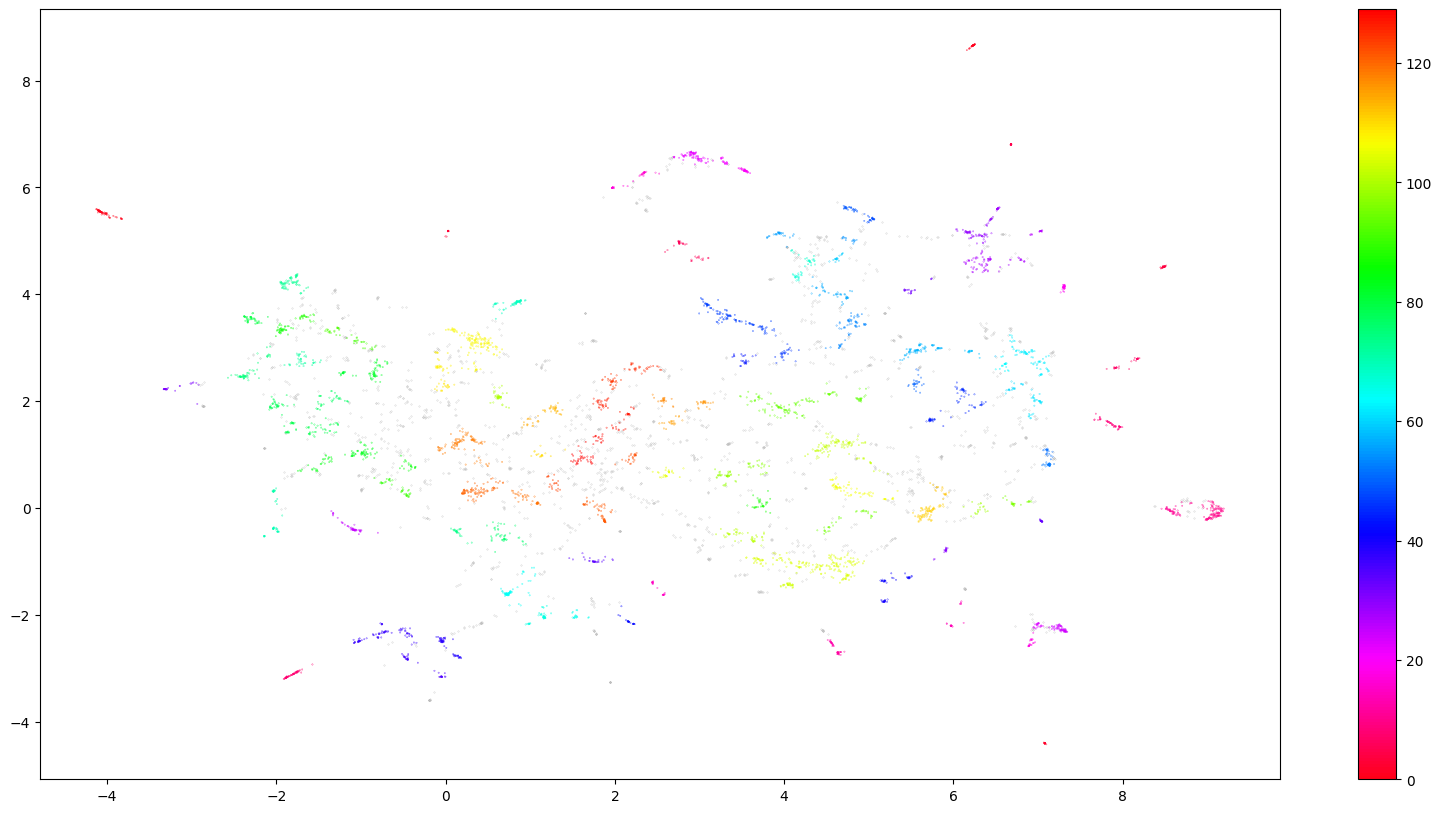

In [15]:
import matplotlib.pyplot as plt

# Prepare data
#umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings4)
result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [19]:
result.labels.nunique()
# 131 clusters 

131

Hyperparameter Searching for HDBSCAN

In [33]:
import umap
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

umap_ = umap.UMAP(n_components=2)# .fit_transform(embeddings4)
# umap_ = umap.UMAP(n_components=2)
# X_umap = umap_.fit_transform(X)

# Define the pipeline with HDBScan and UMAP
pipe = Pipeline([
    ('umap', umap_),
    ('hdbscan', hdbscan.HDBSCAN())
])

# Define the parameter grid for the grid search
param_grid = {'umap__n_neighbors': [5, 10, 15],
              'umap__min_dist': [0.0, 0.1, 0.25, 0.5],
              'umap__metric': ['euclidean', 'cosine', 'manhattan'],
              'hdbscan__min_samples': [5, 10, 15],
              'hdbscan__min_cluster_size': [10, 20, 30]
}

# Define the grid search with cross-validation
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring=silhouette_score)

# Fit the grid search to the data
grid.fit(embeddings4)

# Print the best parameters and the best score
print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Best parameters: {'hdbscan__min_cluster_size': 10, 'hdbscan__min_samples': 5, 'umap__metric': 'euclidean', 'umap__min_dist': 0.0, 'umap__n_neighbors': 5}
Best score: nan


Best parameters: {'hdbscan__min_cluster_size': 10, 'hdbscan__min_samples': 5, 'umap__metric': 'euclidean', 'umap__min_dist': 0.0, 'umap__n_neighbors': 5}
Best score: nan

In [42]:
from sklearn.metrics import silhouette_score

umap_embeddings1 = umap.UMAP(
           n_components=2,
           n_neighbors=5,
           metric='euclidean',
           min_dist=0.0).fit_transform(embeddings4)
cluster1 = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',  
                          min_samples=5,                    
                          cluster_selection_method='eom').fit(umap_embeddings1)
# Compute the silhouette score for each cluster
silhouette_scores = silhouette_score(umap_embeddings1, cluster1.labels_)

# Print the average silhouette score
print('Average silhouette score: {:.3f}'.format(silhouette_scores))

Average silhouette score: 0.547


In [61]:
num_clusters = len(set(cluster1.labels_)) - (1 if -1 in cluster1.labels_ else 0)
print("Number of clusters:", num_clusters)

Number of clusters: 297


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


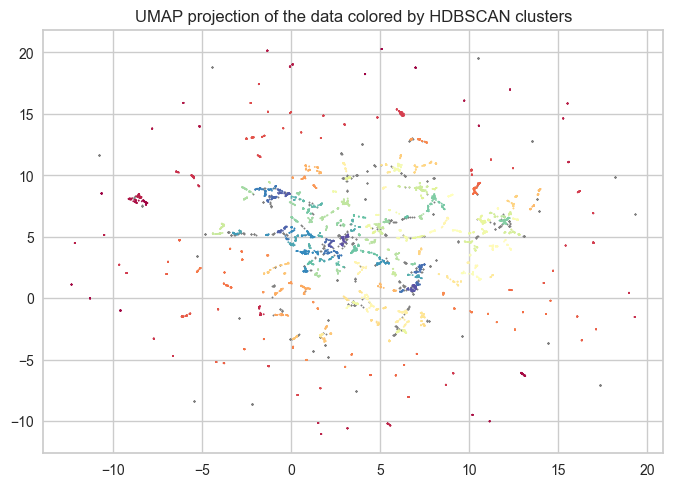

In [53]:
# Create a scatter plot of the embeddings, colored by cluster label
clustered = (cluster1.labels_ >= 0)
plt.scatter(umap_embeddings1[~clustered, 0], umap_embeddings1[~clustered, 1], s=1, c=(0.5,0.5,0.5))
plt.scatter(umap_embeddings1[clustered, 0], umap_embeddings1[clustered, 1], s=1, c=cluster1.labels_[clustered], cmap='Spectral')
plt.title('UMAP projection of the data colored by HDBSCAN clusters')

# Show the plot
plt.show()


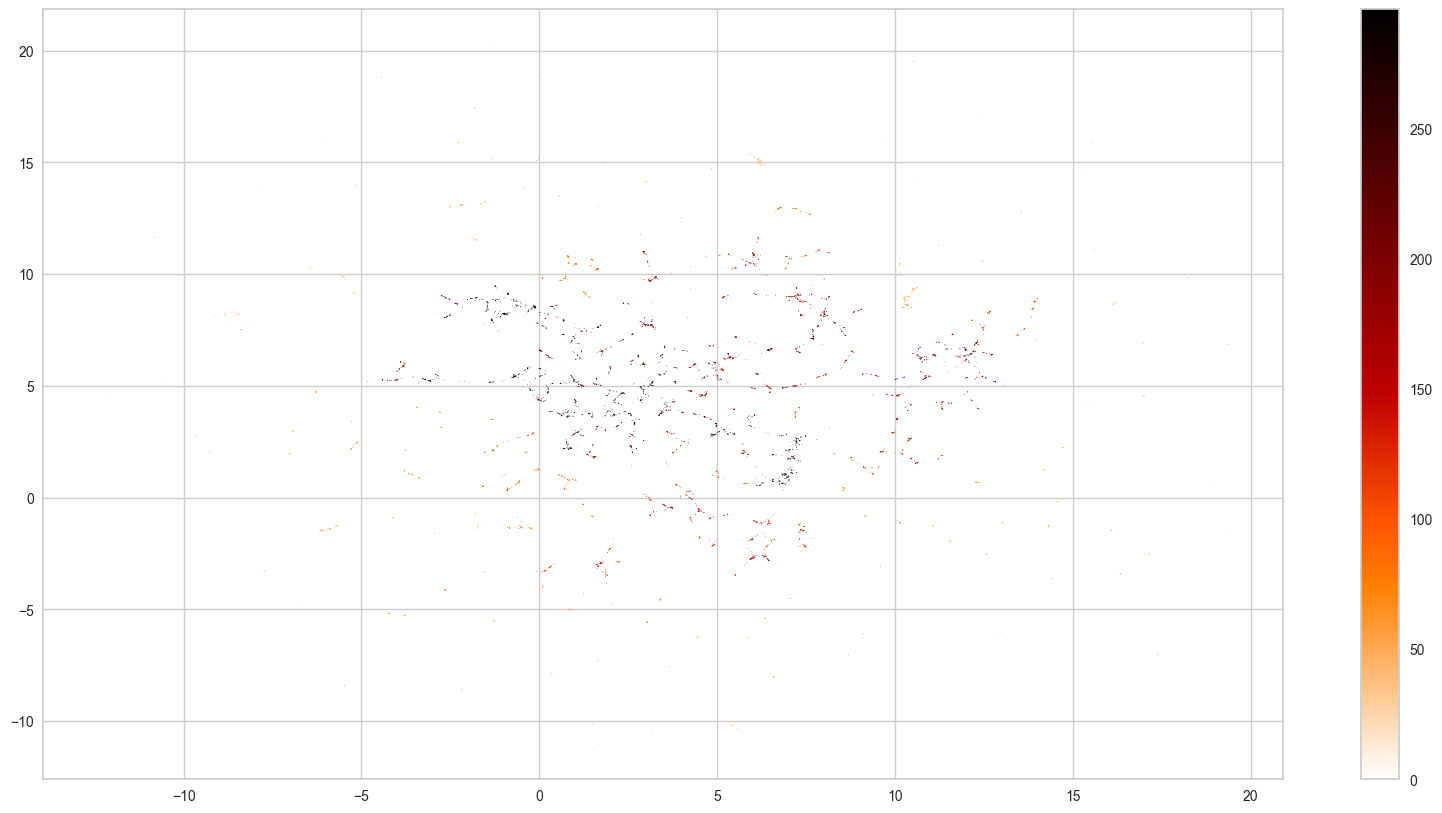

In [52]:
import matplotlib.pyplot as plt

# Prepare data
#umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings4)
result = pd.DataFrame(umap_embeddings1, columns=['x', 'y'])
result['labels'] = cluster1.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='gist_heat_r')
plt.colorbar()

### Assigning clusters

In [ ]:
umap_embeddings.shape

(6806, 2)

In [64]:
data_df.head(1)

,Unnamed: 0.1,unique_id,Unnamed: 0,date,time,date_time,agency,agency_name,inquiry_name,brief_description,call_resolution,inquiry_with_description
0,947,120986760,947,2017-01-01,12:00:05 AM,2017-01-01T00:00:05.000,3-1-1,3-1-1 Call Center,Language Assistance,Connect to Language Line.,Transfer to City Agency,Language Assistance Connect to Language Line.


In [65]:
# Create a new dataframe with the cluster labels
# Merge the original dataframe and the cluster labels dataframe on the index
clustered_df = unique_inq_df.merge(pd.DataFrame({'cluster_label': cluster1.labels_}), left_index=True, right_index=True)

# Merging embeddings
clustered_df = clustered_df.merge(pd.DataFrame(umap_embeddings1), left_index=True, right_index=True)
clustered_df.rename(columns={0:'embed_0',1:'embed_1'},inplace=True)
clustered_df = data_df.merge(clustered_df, left_on='inquiry_with_description', right_on='Inquiry_names')

In [66]:
clustered_df.head(2)

,Unnamed: 0.1,unique_id,Unnamed: 0,date,time,date_time,agency,agency_name,inquiry_name,brief_description,call_resolution,inquiry_with_description,Inquiry_names,cluster_label,embed_0,embed_1
0,947,120986760,947,2017-01-01,12:00:05 AM,2017-01-01T00:00:05.000,3-1-1,3-1-1 Call Center,Language Assistance,Connect to Language Line.,Transfer to City Agency,Language Assistance Connect to Language Line.,Language Assistance Connect to Language Line.,35,0.351894,-7.864037
1,601,120980636,601,2017-01-01,1:48:06 AM,2017-01-01T01:48:06.000,3-1-1,3-1-1 Call Center,Language Assistance,Connect to Language Line.,Transfer to City Agency,Language Assistance Connect to Language Line.,Language Assistance Connect to Language Line.,35,0.351894,-7.864037


In [70]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
clustered_df.to_csv(path+'/clustered_hdbscan_df.csv', sep=',')

In [15]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
# define column names and datatypes
df = dd.read_csv(path+'/clustered_hdbscan_df.csv', usecols=['date','agency','agency_name','inquiry_name','brief_description','call_resolution','inquiry_with_description','cluster_label','embed_0','embed_1'])

In [30]:
# Compute the dataframe to see its contents
df = df.compute()

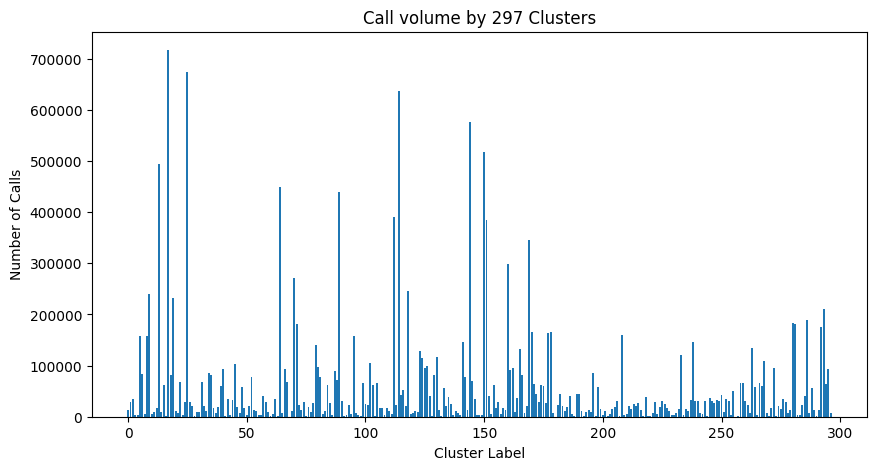

In [28]:
# Count the number of data points in each cluster
counts = df.loc[(df['cluster_label']!=-1)]['cluster_label'].value_counts()

# Plot a histogram of the counts
plt.bar(counts.index, counts.values)
plt.xlabel('Cluster Label')
plt.ylabel('Number of Calls')
plt.title('Call volume by 297 Clusters')
plt.show()

In [29]:
#df.loc[(df['cluster_label']!=-1) & (df['inquiry_name'].str.contains('Harassment'))]

In [35]:
clusters_df = pd.DataFrame(df.groupby(['cluster_label']).count()[['inquiry_name']]).sort_values(by = 'inquiry_name',ascending=False)
clusters_df

,inquiry_name
cluster_label,
-1,1320074
17,717143
25,675138
114,637271
144,575759
...,...
98,576
41,561
180,405


In [37]:
witout_outlier_df = clusters_df.loc[(clusters_df.index!=-1)]

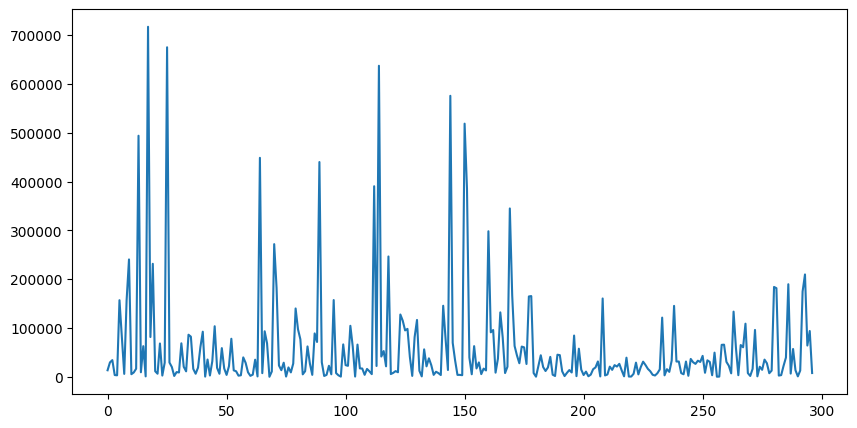

In [46]:
plt.plot(witout_outlier_df.sort_index())

In [43]:
df.head(2)

,date,agency,agency_name,inquiry_name,brief_description,call_resolution,inquiry_with_description,cluster_label,embed_0,embed_1
0,2017-01-01,3-1-1,3-1-1 Call Center,Language Assistance,Connect to Language Line.,Transfer to City Agency,Language Assistance Connect to Language Line.,35,0.351894,-7.864037
1,2017-01-01,3-1-1,3-1-1 Call Center,Language Assistance,Connect to Language Line.,Transfer to City Agency,Language Assistance Connect to Language Line.,35,0.351894,-7.864037


In [45]:
df[df.cluster_label == 1][['inquiry_name']].value_counts()

inquiry_name                                                                                 
Water in Basement - Less Than One Foot                                                           11077
Flooding Street                                                                                   8831
Water in Basement - More Than One Foot - Priority                                                 7810
Street Flooding                                                                                   1449
Flooding Highway - Priority                                                                        394
Highway Flooding                                                                                    62
Water in Basement - More Than One Foot - After Business Hours Sundays and Holidays - Priority        7
Flooding Street - After Business Hours Sundays and Holidays                                          6
Water in Basement - More Than One Foot - During Business Hours and Saturdays - Pri